# Задача 9. Hand-crafted graph features

* **Дедлайн**: 16.05.2025, 23:59
* Основной полный балл: 5
* Максимум баллов: 10


## Задача

- [x] Найти или сгенерировать набор данных для бинарной классификации графов.
- [x] Реализовать функцию `shortest_path_kernel(train_graphs, test_graphs)`, которая принимает тренировочный и тестовые наборы, а возвращает пару `K_train, K_test`
  - Опишите графы с помощью вектора из количества кратчайших путей различной длины
  - Для вычисления длин кратчайших путей можно использовать `nx.shortest_path_length(G)`
  - Ядровая функция для сравнения двух графов - скалярное произведение их двух векторов
  - `K_train` - матрица из ядровых функций для сравнения тренировочных графов между собой
  - `K_test` - матрица из ядровых функций для сравнения тестовых графов с тренировочными
- [x] Используя реализованное ядро обучите модель SVC, подберите гиперпараметры, вычислите различные метрики качества
- [x] (+5 баллов) Также реализовать Weisfeiler-Lehman Kernel и обучить классификатор с ним, сравнить результаты.

In [1]:
!pip install -q torch-geometric

In [2]:
from torch_geometric.datasets import TUDataset

dataset = TUDataset("datasets/", name="FRANKENSTEIN", use_node_attr=False, use_edge_attr=False)
dataset.download()

In [3]:
from sklearn.model_selection import train_test_split
from torch_geometric.utils import to_networkx

import numpy as np

seed = 52
np.random.seed(seed)

graphs = [to_networkx(graph) for graph in dataset]
labels = [graph.y.item() for graph in dataset]


train_idx, test_idx = train_test_split(
    list(range(len(dataset))),
    test_size=0.2,
    stratify=labels,
    random_state=seed
)

train_graphs = [graphs[idx] for idx in train_idx]
train_graph_labels = [labels[idx] for idx in train_idx]
test_graphs = [graphs[idx] for idx in test_idx]
test_graph_labels = [labels[idx] for idx in test_idx]

print(f"Train size: {len(train_graphs)}")
print(f"Test size: {len(test_graphs)}")

Train size: 3469
Test size: 868


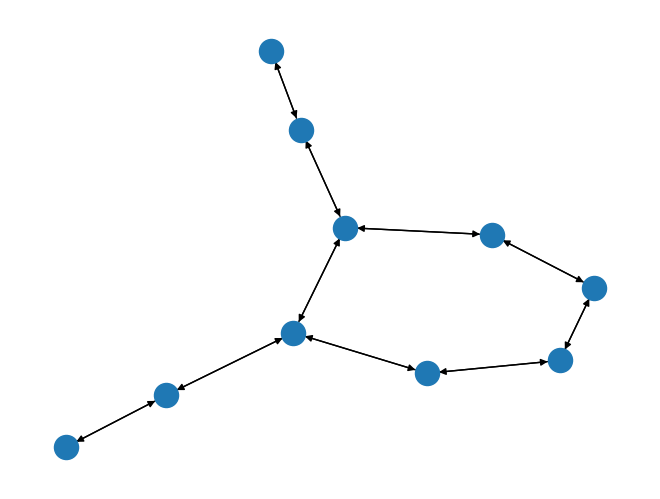

In [4]:
import networkx as nx

graph_0 = next(graph for graph, label in zip(train_graphs, train_graph_labels) if label == 0)
nx.draw(graph_0)

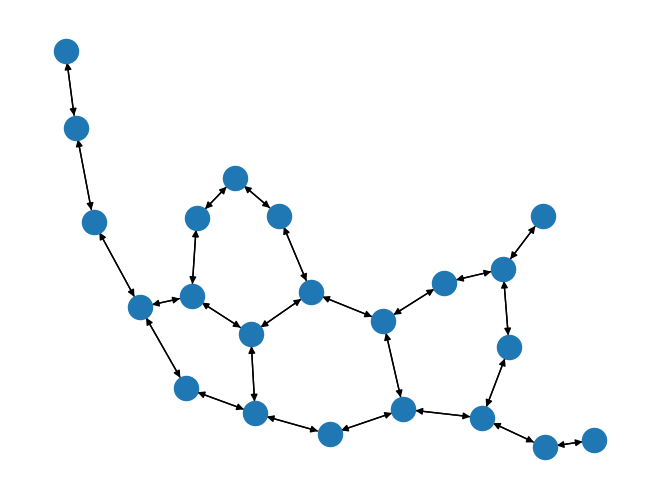

In [5]:
graph_1 = next(graph for graph, label in zip(train_graphs, train_graph_labels) if label == 1)
nx.draw(graph_1)

In [6]:
print("is_strongly_connected: ", all(nx.is_strongly_connected(g) for g in graphs))

max_length = max(
    length
    for graph in graphs
    for source in graph.nodes
    for target, length in nx.shortest_path_length(graph, source=source).items()
)

print("max shortest_path_length", max_length)

is_strongly_connected:  False
max shortest_path_length 53


## Shortest path kernel

In [7]:
def graph_shortest_paths_length(graph: nx.Graph) -> np.ndarray:
    path_lengths = np.zeros(max_length, dtype=int)

    for source in graph.nodes:
        lengths = nx.shortest_path_length(graph, source=source)
        for target, length in lengths.items():
            if source < target:
              path_lengths[length - 1] += 1

    return path_lengths


def shortest_path_kernel(train_graphs, test_graphs):
  tr = np.array([graph_shortest_paths_length(graph) for graph in train_graphs])
  ts = np.array([graph_shortest_paths_length(graph) for graph in test_graphs])

  K_train = np.dot(tr, tr.T)
  K_test = np.dot(ts, tr.T)

  return K_train, K_test

K_train, K_test = shortest_path_kernel(train_graphs, test_graphs)
print(K_train.shape, K_test.shape)

(3469, 3469) (868, 3469)


Обучим модель, подберем гиперпараметры

In [8]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

C = [0.05, 0.1, 0.5, 1]
gamma = [0.001, 0.01, 0.1, 1]
svm = SVC(kernel="precomputed", probability=True, random_state=seed)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

grid_svm = GridSearchCV(
    estimator=svm,
    param_grid=dict(C=C, gamma=gamma),
    cv = cv,
    refit=True,
    verbose=2,
    return_train_score=False)

grid_svm.fit(K_train, train_graph_labels)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ................................C=0.05, gamma=0.001; total time=   5.2s
[CV] END ................................C=0.05, gamma=0.001; total time=   8.6s
[CV] END ................................C=0.05, gamma=0.001; total time=   9.4s
[CV] END ................................C=0.05, gamma=0.001; total time=  10.8s
[CV] END ................................C=0.05, gamma=0.001; total time=   7.8s
[CV] END .................................C=0.05, gamma=0.01; total time=   6.1s
[CV] END .................................C=0.05, gamma=0.01; total time=   7.7s
[CV] END .................................C=0.05, gamma=0.01; total time=   6.1s
[CV] END .................................C=0.05, gamma=0.01; total time=   8.1s
[CV] END .................................C=0.05, gamma=0.01; total time=   5.2s
[CV] END ..................................C=0.05, gamma=0.1; total time=   5.7s
[CV] END ..................................C=0.0

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=52, shuffle=True),
             estimator=SVC(kernel='precomputed', probability=True,
                           random_state=52),
             param_grid={'C': [0.05, 0.1, 0.5, 1],
                         'gamma': [0.001, 0.01, 0.1, 1]},
             verbose=2)

In [9]:
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
)

print("Best score: ", grid_svm.best_score_)
print("Best param: ", grid_svm.best_params_)

best_model = grid_svm.best_estimator_
y_pred = best_model.predict(K_test)

print("Test set performance:")
print("Accuracy:", accuracy_score(test_graph_labels, y_pred))
print("Precision:", precision_score(test_graph_labels, y_pred))
print("Recall:", recall_score(test_graph_labels, y_pred))
print("F1 score:", f1_score(test_graph_labels, y_pred))

Best score:  0.6203459044957604
Best param:  {'C': 0.1, 'gamma': 0.001}

Test set performance:
Accuracy: 0.6255760368663594
Precision: 0.6258064516129033
Recall: 0.8066528066528067
F1 score: 0.7048138056312443


## Weisfeiler-Lehman Kernel

In [10]:
h = 3 # при h == 3 показатели лучше. Проверял на 2..4

max_nodes = max([len(graph.nodes) for graph in graphs])


def wls(graphs, max_nodes) -> np.ndarray:
  curr = np.ones((len(graphs), max_nodes), dtype=int)
  prev = np.ones((len(graphs), max_nodes), dtype=int)
  colors_dict = {(1,): 1}

  for _ in range(h):
    for i, graph in enumerate(graphs):
      for node in graph.nodes:
        n_nodes = graph[node].keys()
        new_node_color = tuple(sorted([prev[i, node]] + [prev[i, n] for n in n_nodes]))
        if new_node_color not in colors_dict:
          colors_dict[new_node_color] = len(colors_dict) + 1
        curr[i, node] = colors_dict[new_node_color]
    prev = curr.copy()

  maxi = np.unique_values(curr).shape[0]
  s = np.zeros((len(graphs), maxi), dtype=int)
  colors_dicti = {}
  for i in range(len(graphs)):
    nums, counts = np.unique(curr[i], return_counts=True)
    for (num, count) in zip(nums, counts):
      if num not in colors_dicti:
        colors_dicti[num] = len(colors_dicti)
      s[i, colors_dicti[num]] = count
  return s

def wl_kernel():
  wl = wls(graphs, max_nodes)
  tr = np.array([wl[idx] for idx in train_idx])
  ts = np.array([wl[idx] for idx in test_idx])

  K_train = np.dot(tr, tr.T)
  K_test = np.dot(ts, tr.T)

  return K_train, K_test

K_train2, K_test2 = wl_kernel()
print(K_train2.shape, K_test2.shape)

(3469, 3469) (868, 3469)


Посмотрим на работу алгоритма на минималистичном примере

In [11]:
edges = [
    (0, 1),
    (0, 2),
    (0, 3),
    (0, 4),
    (0, 5),
    (1, 3),
    (2, 4),
    (3, 5)
]
graph1 = nx.Graph(edges)

edges = [
    (0, 1),
    (0, 2),
    (2, 3),
    (1, 2),
    (2, 4),
    (4, 5),
]
graph2 = nx.Graph(edges)

wls = wls([graph1, graph2], 6)
display(wls)


array([[1, 2, 2, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 2, 1, 1, 1, 1]])

Обучим модель, подберем гиперпараметры

In [12]:
C = [0.05, 0.1, 0.5, 1]
gamma = [0.001, 0.01, 0.1, 1]
svm = SVC(kernel="precomputed", probability=True, random_state=seed)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

grid_svm2 = GridSearchCV(
    estimator=svm,
    param_grid=dict(C=C, gamma=gamma),
    cv = cv,
    refit=True,
    verbose=2,
    return_train_score=False)

grid_svm2.fit(K_train2, train_graph_labels)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ................................C=0.05, gamma=0.001; total time=   1.3s
[CV] END ................................C=0.05, gamma=0.001; total time=   1.2s
[CV] END ................................C=0.05, gamma=0.001; total time=   1.3s
[CV] END ................................C=0.05, gamma=0.001; total time=   1.6s
[CV] END ................................C=0.05, gamma=0.001; total time=   1.8s
[CV] END .................................C=0.05, gamma=0.01; total time=   1.3s
[CV] END .................................C=0.05, gamma=0.01; total time=   1.2s
[CV] END .................................C=0.05, gamma=0.01; total time=   1.3s
[CV] END .................................C=0.05, gamma=0.01; total time=   1.2s
[CV] END .................................C=0.05, gamma=0.01; total time=   1.3s
[CV] END ..................................C=0.05, gamma=0.1; total time=   1.3s
[CV] END ..................................C=0.0

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=52, shuffle=True),
             estimator=SVC(kernel='precomputed', probability=True,
                           random_state=52),
             param_grid={'C': [0.05, 0.1, 0.5, 1],
                         'gamma': [0.001, 0.01, 0.1, 1]},
             verbose=2)

In [13]:

print("Best score: ", grid_svm2.best_score_)
print("Best param: ", grid_svm2.best_params_)

best_model2 = grid_svm2.best_estimator_
y_pred = best_model2.predict(K_test2)

print("Test set performance:")
print("Accuracy:", accuracy_score(test_graph_labels, y_pred))
print("Precision:", precision_score(test_graph_labels, y_pred))
print("Recall:", recall_score(test_graph_labels, y_pred))
print("F1 score:", f1_score(test_graph_labels, y_pred))

Best score:  0.7198036353655949
Best param:  {'C': 0.1, 'gamma': 0.001}

Test set performance:
Accuracy: 0.7096774193548387
Precision: 0.723196881091618
Recall: 0.7713097713097713
F1 score: 0.7464788732394366


## Сравнение результатов

| Method | Accuracy | Precision | Recall | F1 score |
|--------|----------|-----------|--------|----------|
| SP     | 0.63     | 0.63      | **0.81** | 0.70     |
| **WL** | **0.71** | **0.72**  | 0.77     | **0.75** |


WL показал более высокие результаты accuracy на тестовом датасете, чем SP.
WL также имеет более высокие показатели precision и F1. Однако, recall выше у SP.

Помимо этого, на WL оказался гораздо быстрее процесс подбора гиперпараметров (и переобучения модели).